In [1]:
# Import Library

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from PIL import Image

import tensorflow as tf
from keras import layers
from tensorflow.keras import applications 
from keras.applications import MobileNetV2
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras import models


from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix

from tqdm import tqdm

In [2]:
train_df = pd.read_csv('../input/valid-and-test-ta/x_train_8.csv')
valid_df = pd.read_csv('../input/valid-and-test-ta/x_valid_8.csv')
print(train_df.shape)
print(valid_df.shape)
train_df.head()

(3297, 2)
(365, 2)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [3]:
#train_df['diagnosis'].value_counts()
#train_df['diagnosis'].hist()
def plot_classes(df,title):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "Blues_d")
    plt.title('Output Class Distribution ' + str(title))
    plt.show() 

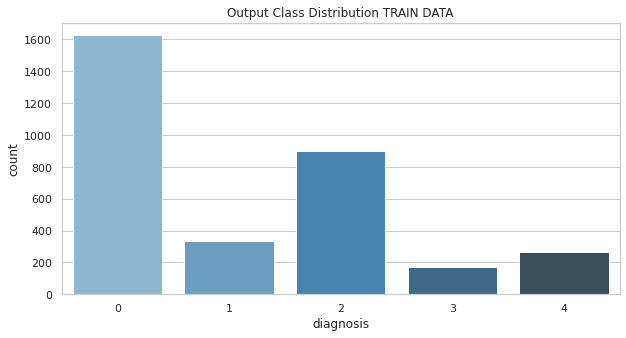

In [4]:
plot_classes(train_df,"TRAIN DATA")

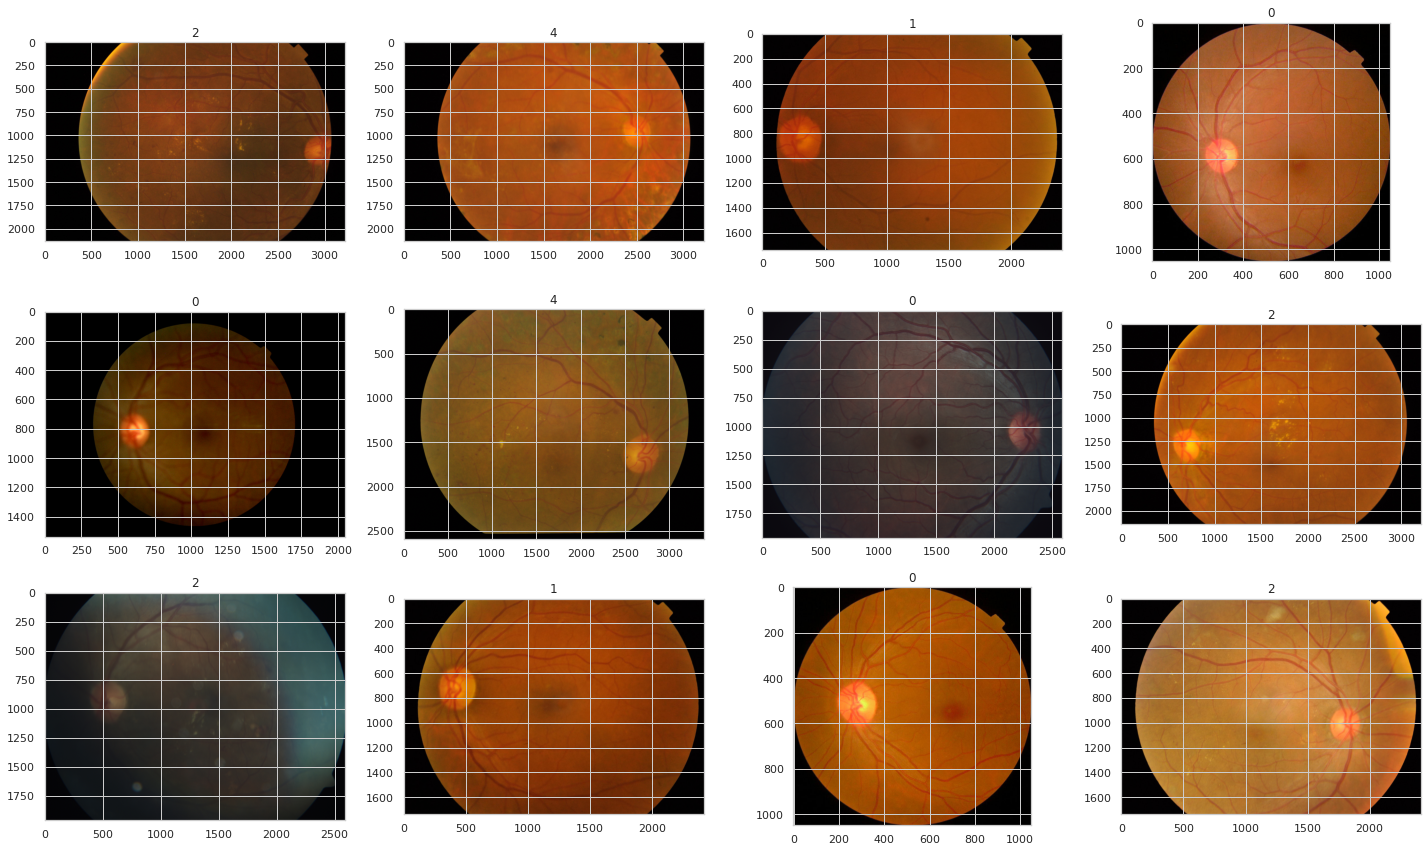

In [5]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'../input/aptos2019-blindness-detection/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

In [6]:
#resample
from sklearn.utils import resample
X=train_df
normal=X[X.diagnosis==0]
mild=X[X.diagnosis==1]
moderate=X[X.diagnosis==2]
severe=X[X.diagnosis==3]
pdr=X[X.diagnosis==4]

#downsampled
mild = resample(mild,
                replace=True, # sample with replacement
                n_samples=700, # match number in majority class
                random_state=2020) # reproducible results
moderate = resample(moderate,
                    replace=False, # sample with replacement
                    n_samples=700, # match number in majority class
                    random_state=2020) # reproducible results
severe = resample(severe,
                  replace=True, # sample with replacement
                  n_samples=700, # match number in majority class
                  random_state=2020) # reproducible results
normal = resample(normal,
                  replace=False, # sample with replacement
                  n_samples=700, # match number in majority class
                  random_state=2020) # reproducible results
pdr = resample(pdr,
               replace=True, # sample with replacement
               n_samples=700, # match number in majority class
               random_state=2020) # reproducible results    

# combine minority and downsampled majority
sampled = pd.concat([normal, mild, moderate, severe, pdr])

# checking counts
sampled.diagnosis.value_counts()

train_df = sampled
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [7]:
def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.BILINEAR)
    
    return im

In [8]:
N = train_df.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.float32)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        f'../input/aptos2019-blindness-detection/train_images/{image_id}.png'
    )
    
N = valid_df.shape[0]
x_val = np.empty((N, 224, 224, 3), dtype=np.float32)

for i, image_id in enumerate(tqdm(valid_df['id_code'])):
    x_val[i, :, :, :] = preprocess_image(
        f'../input/aptos2019-blindness-detection/train_images/{image_id}.png'
    )

100%|██████████| 365/365 [00:52<00:00,  6.89it/s]


In [9]:
y_train = train_df['diagnosis']
y_val = valid_df['diagnosis']
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(3500, 224, 224, 3)
(3500,)
(365, 224, 224, 3)
(365,)


In [10]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.1,  # set range for random zoom
        rotation_range = 360,
        fill_mode='constant',
        cval=0.,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)

In [11]:
class Metrics(Callback):
    def __init__(self, xval, yval):
        super().__init__()
        self.xval = xval
        self.yval = yval
        
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val = self.xval
        y_val = self.yval
        
        y_pred = self.model.predict(X_val)
        y_pred = np.clip(y_pred,0,4)
        y_pred = y_pred.astype(int)

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return
    
kappa_metrics = Metrics(x_val, y_val)

In [12]:
efficientnet = applications.EfficientNetB6(include_top=False, weights='imagenet', input_shape=(224,224,3))

165240832/165234480 [==============================] - 1s 0us/step


In [13]:
def build_model():
    model = Sequential()
    model.add(efficientnet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256))
    model.add(layers.Dense(256))
    model.add(layers.Dense(1))
    
    model.compile(
        loss='mse',
        optimizer=Adam(lr=0.0001),
        metrics=['accuracy']
    )
    
    return model

In [14]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb6 (Functional)  (None, 7, 7, 2304)        40960143  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               590080    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 41,616,272
Trainable params: 41,391,833
Non-trainable params: 224,439
_________________________________________________________________


In [15]:
history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=10,
    validation_data = (x_val, y_val),
    callbacks=[kappa_metrics]
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
109/109 [==============================] - 126s 910ms/step - loss: 2.3664 - accuracy: 0.2937 - val_loss: 0.8529 - val_accuracy: 0.4904
val_kappa: 0.4754
Validation Kappa has improved. Saving model.
Epoch 2/10
109/109 [==============================] - 95s 864ms/step - loss: 0.8249 - accuracy: 0.3131 - val_loss: 0.4338 - val_accuracy: 0.5096
val_kappa: 0.7893
Validation Kappa has improved. Saving model.
Epoch 3/10
109/109 [==============================] - 95s 864ms/step - loss: 0.6724 - accuracy: 0.3399 - val_loss: 0.5019 - val_accuracy: 0.5315
val_kappa: 0.7361
Epoch 4/10
109/109 [==============================] - 95s 863ms/step - loss: 0.5836 - accuracy: 0.3313 - val_loss: 0.3573 - val_accuracy: 0.5397
val_kappa: 0.7896
Validation Kappa has improved. Saving model.
Epoch 5/10
109/109 [==============================] - 95s 863ms/step - loss: 0.4913 - accuracy: 0.3302 - val_loss: 0.3492 - val_accuracy: 0.5260
val_kappa: 0.7962
Validation Kappa has improved. Saving model.
Epoc

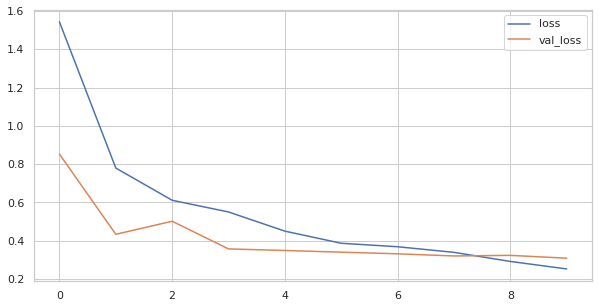

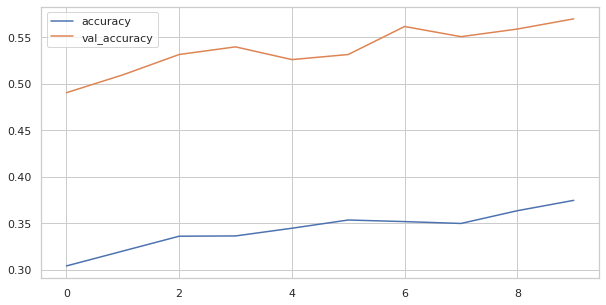

In [16]:
#plotting accuracies and loss
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()
history_df.to_csv('history.csv', index = False)

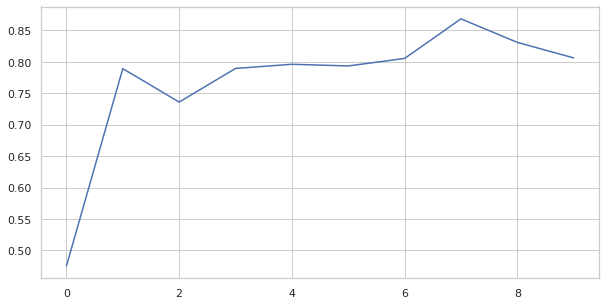

In [17]:
#plotting the QWK score
plt.plot(kappa_metrics.val_kappas)

In [18]:
model.load_weights('model.h5')
y_val_pred = model.predict(x_val)
#clipping the value to range of 0-4, and round it to the nearest integer
y_val_pred = np.clip(y_val_pred,0,4).astype(int)

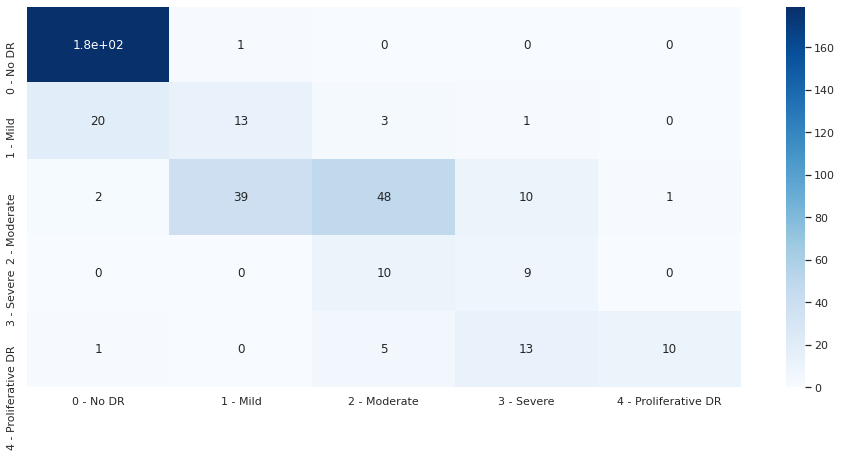

In [19]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(valid_df['diagnosis'].astype('int'), y_val_pred)
df_cm = pd.DataFrame(cnf_matrix, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

In [20]:
kappa_val = cohen_kappa_score(
            valid_df['diagnosis'].astype('int'),
            y_val_pred, 
            weights='quadratic'
        )
print(kappa_val)

0.8684588599118513


In [21]:
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
N = test_df.shape[0]
x_test = np.empty((N, 224, 224, 3), dtype=np.float32)

for i, image_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image(
        f'../input/aptos2019-blindness-detection/test_images/{image_id}.png'
    )

y_test_pred = model.predict(x_test)
#clipping the value to range of 0-4, and round it to the nearest integer
y_test_pred = np.clip(y_test_pred,0,4).astype(int)

test_df['diagnosis'] = y_test_pred
test_df.to_csv('submission.csv')

100%|██████████| 1928/1928 [01:51<00:00, 17.30it/s]
